# Определение свободных мест на парковке

***
**Цель**: Используя  инструментарий машинного обучения и язык программирования python программу для определения свободных мест на парковке. 
***
**Задачи** : 
<dd> 1. Обработать данные из датасета. <dd>
<dd> 2. Обучить классификатор на основе полученных тренировочных данных, который будет определять свободно ли парковочное место или нет.<dd>
<dd> 2. Протестировать классификатор.<dd>

## Про датасет

Датасет взят с kaggle (https://www.kaggle.com/datasets/iasadpanwhar/parking-lot-detection-counter/data). Он содержит изображения с парковочными местами, "маску" парковки, и файл для тестирования модели, которое содержит видеозапись с видом свехру парковки с изменяющимся количеством парковочных мест.

## Источники 

<dd> 1. Kaggle (https://www.kaggle.com/datasets/iasadpanwhar/parking-lot-detection-counter/data). <dd>
<dd> 2. Учебник по машинному обучению от ШАДа (https://education.yandex.ru/handbook/ml). <dd>
<dd> 3. Документация tensorflow (https://www.tensorflow.org). <dd>
<dd> 4. Документация opecv (https://docs.opencv.org/4.x/index.html). <dd>
<dd> 5. Ian Goodfellow, Yoshua Bengio, Aaron Courville - Deep Learning (2017, MIT). <dd>

## Метод решения

Для классификации изображений я буду использовать **сверточную нейронную сеть**, которая считается одной из самой эффективных архитектур нейронных сетей для распознования образов на изображениях. 

## Предобработка данных и настройка классификатора

In [1]:
# Импорт библиотек
import numpy as np
import tensorflow as tf
import cv2
import random
from os import listdir
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

Посмотрим на содержимое изображений, представленных в датасете.

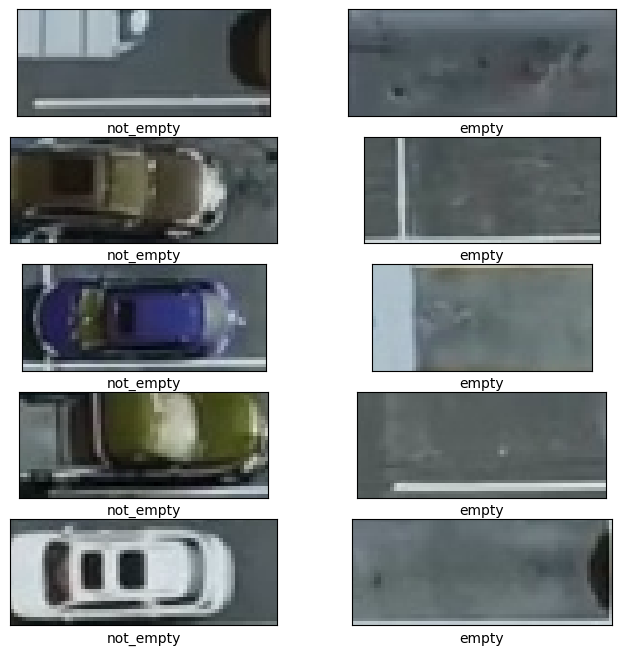

In [2]:
not_empty_images = [cv2.imread("parking/clf-data/not_empty/" + img_name) for img_name in listdir("parking/clf-data/not_empty")]

empty_images = [cv2.imread("parking/clf-data/empty/" + img_name) for img_name in listdir("parking/clf-data/empty")]

plt.figure(figsize=(8, 8))
for i in range(5):
    plt.subplot(5,2, 2*i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(not_empty_images[i])
    plt.xlabel("not_empty")
for i in range(5):
    plt.subplot(5,2,2*i+1+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(empty_images[i])
    plt.xlabel("empty")

plt.show()

Изображения содержат занятые и свободные парковочные места. Изображения отличаются по размеру. Преобразуем все изображения к формату (64, 64) и также нормализуем их к диапазону [0, 1].

In [3]:
IMAGE_SHAPE = (64, 64, 3)

not_empty_images = [cv2.resize(img, IMAGE_SHAPE[:2])/255.0 for img in not_empty_images]
empty_images = [cv2.resize(img, IMAGE_SHAPE[:2])/255.0 for img in empty_images]

Далее хочется объединить данные в один набор и перемешать для того чтобы потом получить относительно сбалансированные выборки для обучения и тестирования модели.

In [4]:
not_empty_labels = [[0, 1]]*len(not_empty_images)
empty_labels = [[1, 0]]*len(empty_images)

images = not_empty_images + empty_images
labels = not_empty_labels + empty_labels

combined = list(zip(images, labels))
random.shuffle(combined)

images, labels = zip(*combined)

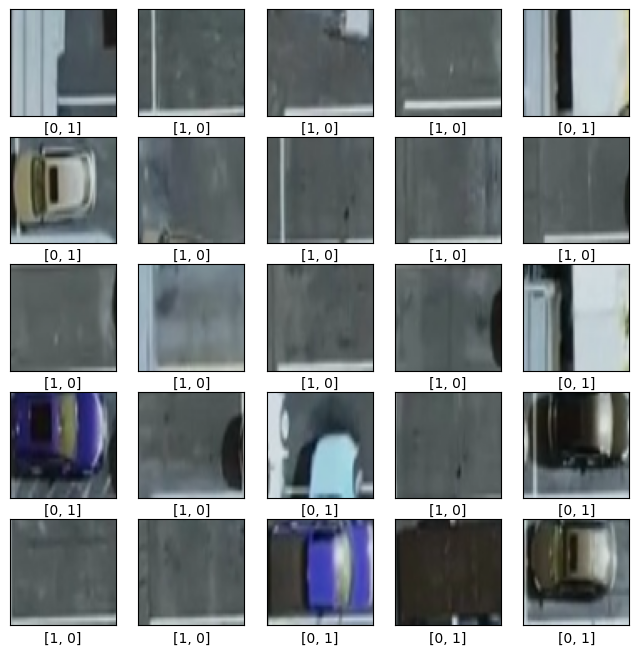

In [5]:
# Взглянем на преобразованные изображения
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    plt.xlabel(labels[i])

plt.show()

Теперь пора настроить модель. Я буду использовать сверточную нейронную сеть, состоящую из 3 слоев. На вход подается изображение (64, 64, 3), проходя сквозь слои оно обрезается и преобразуется в свертки. В последнем слое мы линейно преобразуем получившийся тензор для выполнения классификации и с помощью сигмоидной функции получаем вероятность принадлежности к одному из двух классов (занято/свободно).

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(2))


model.summary()

/Users/vladimirbogatyrev/Desktop/Code/YandexIntern/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,338 (2.47 MB)

 Trainable params: 646,338 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Пора разделить исходную выборку на тестовую и обучающую

In [7]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.3)
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [8]:
N_EPOCHS = 10

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[metrics.AUC(from_logits=True)])

history = model.fit(train_images, train_labels, epochs=N_EPOCHS)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - auc: 0.9079 - loss: 0.3368
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - auc: 0.9998 - loss: 0.0382
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - auc: 1.0000 - loss: 0.0097
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - auc: 1.0000 - loss: 0.0101
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - auc: 1.0000 - loss: 0.0087
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - auc: 1.0000 - loss: 0.0034
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - auc: 1.0000 - loss: 0.0018
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - auc: 1.0000 - loss: 0.0013
Epoch 9/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - auc: 1.0000 - loss: 0.0011
Epoch 10/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - auc: 1.0000 - loss: 8.8747e-04


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


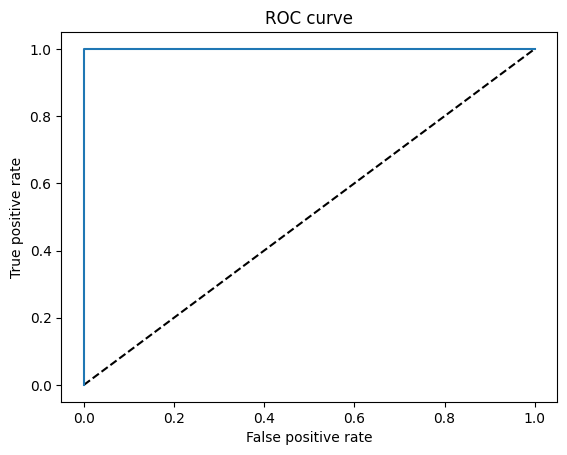

In [9]:
labels_predicted = [np.argmax(prediction) for prediction in model.predict(test_images)]
test_labels_marks = [1 if list(label) == [0, 1] else 0 for label in test_labels]
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels_marks, labels_predicted)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

ROC кривая показывает, что нас классификатор идеальный. Проверим это на практике, применив классификатор для выполнения исходной задачи определения свободных парковочных мест.

## Применение классификатора

Будем делить каждый фрейм на отдельные парковочные места с помощью маски и к каждому из них применять классификатор. В датасете есть видео с видом сверху парковки:

In [10]:
from IPython.display import Video

Video("parking/parking_crop.mp4")

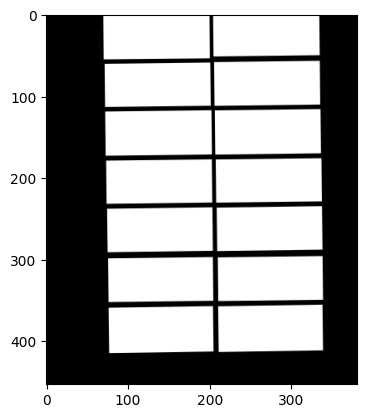

In [11]:
parking_mask = cv2.imread("parking/mask_crop.png")
plt.imshow(parking_mask)

In [12]:
parking_video = cv2.VideoCapture("parking/parking_crop.mp4")

In [13]:
# Функция для определения занятости места (input: изображение места np.array, output: 0 - занято, 1 - свободно)
def empty_or_not(spot_bgr):
    if spot_bgr is None or spot_bgr.size == 0:
        return 0
    try:
        img_resized = cv2.resize(spot_bgr, IMAGE_SHAPE[:2])/255.0
        img_resized = np.expand_dims(img_resized, 0)
        prediction = model.predict(img_resized)
        y_output = np.argmax(prediction)
        return 0 if y_output == 0 else 1
    except Exception as e:
        print(f"Error processing spot: {e}")
        return 0

# Функция для получения параметров парковочных мест (input: cv2.connectedComponentsWithStats(); output: slots - list параметров мест)
def get_parking_spots_bboxes(connected_components):
    (totalLabels, label_ids, values, centroid) = connected_components
    parking_boxes = []
    coef = 1
    for i in range(1, totalLabels):
        x0 = int(values[i, cv2.CC_STAT_LEFT] * coef)
        y0 = int(values[i, cv2.CC_STAT_TOP] * coef)
        width = int(values[i, cv2.CC_STAT_WIDTH] * coef)
        heigth = int(values[i, cv2.CC_STAT_HEIGHT] * coef)
        parking_boxes.append([x0, y0, width, heigth])
    return parking_boxes

# Функция для визуализации рамок парковочных мест (input: image np.array, bboxes list; парковочное место зеленое - свободно, иначе - занято)
def visualize_parking_spots(image, bboxes, title="Parking Spots"):
    for bbox in bboxes:
        x, y, w, h = bbox
        if w > 0 and h > 0:  # Ensure valid bounding box dimensions
            spot = image[y:y+h, x:x+w]
            if spot.shape[0] > 0 and spot.shape[1] > 0:
                status = empty_or_not(spot)
                color = (0, 255, 0) if status == 0 else (0, 0, 255)
                cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Функция для извлечения кадра из видео (для первоначальной оценки работы модели) (input: video_path string, frame_number=0 int)
def extract_frame_from_video(video_path, frame_number=0):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    if ret:
        return frame
    else:
        raise ValueError("Unable to extract frame from video.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


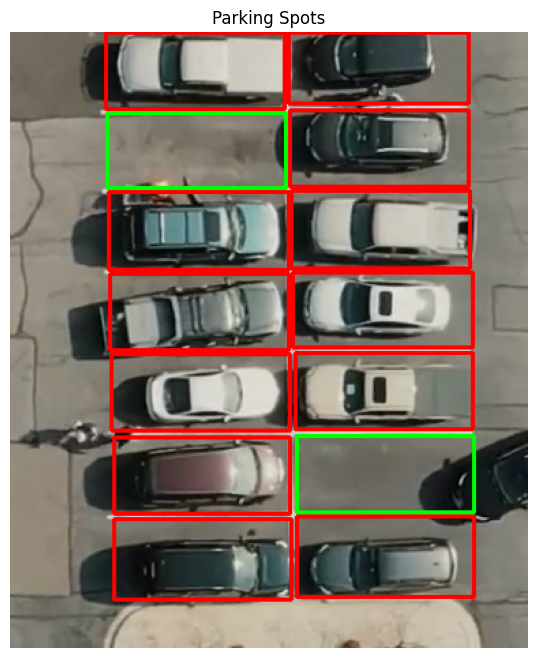

In [14]:
mask_img_path = "parking/mask_crop.png"
mask_img = cv2.imread(mask_img_path, cv2.IMREAD_GRAYSCALE)

connected_components = cv2.connectedComponentsWithStats(mask_img, connectivity=8, ltype=cv2.CV_32S)
parking_bboxes = get_parking_spots_bboxes(connected_components)

video_path = "parking/parking_crop_loop.mp4"
example_frame = extract_frame_from_video(video_path, 160)
visualize_parking_spots(example_frame, parking_bboxes)

In [15]:
# Функция для обработки видео (input: video_path string, bboxes list, model models.Sequential(), output_path string)
def process_video(video_path, bboxes, model, output_path):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_FPS, 5)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, 5, (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        if frame_count%60 == 0:
            for bbox in bboxes:
                x, y, w, h = bbox
                if w > 0 and h > 0: 
                    spot = frame[y:y+h, x:x+w]
                    if spot.shape[0] > 0 and spot.shape[1] > 0:
                        status = empty_or_not(spot)
                        color = (0, 255, 0) if status == 0 else (0, 0, 255)
                        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        
            out.write(frame)
    
    cap.release()
    out.release()

input_video_path = "parking/parking_crop_loop.mp4"
output_video_path = "processed_parking_video.mp4"
# process_video(input_video_path, parking_bboxes, model, output_video_path)

In [16]:
Video(output_video_path)

Стоит отметить, что модель может быть доработана в плане производительности. Путем подбора гиперпараметров (размер входного изображения, количество эпох, размер батча и т.д) можно существенно снизить расход вычислительных ресурсов если это потребуется. Также можно протестировать реакцию модели на разного рода экстра ситуации, например, что будет если на парковочное место попадет кот или пакет? Обучая модель на новых данных можно поддерживать ее актуальность и устойчивость к разного рода ситуациям.